In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'CTC-A.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,3654,-2440,1214,207,662,880,1624,8510,0,...,1961,0,588,4579,2132,8922,-484,-388,78.46,2015-02-14
1,2015-03-31,2515,-1633,882,88,291,1105,1891,8452,0,...,1897,0,587,4434,2130,8869,-185,-75,77.90,2015-05-10
2,2015-06-30,3258,-2206,1052,186,1076,664,1769,8732,0,...,1795,0,288,3925,2974,9232,550,-75,77.28,2015-08-09
3,2015-09-30,3127,-2103,1024,220,846,1065,2137,9101,0,...,2178,0,289,4399,2971,9671,-7,-44,76.22,2015-11-09
4,2015-12-31,3380,-2203,1177,242,900,915,1764,8692,0,...,1957,0,24,3884,2971,9198,621,-105,74.94,2016-02-14


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-12-31,2024-02-14,55.76,4443,-2906,1537,197,311,1151,2693,...,2255,21978,2689,0,561,6389,4404,15533,870,-353
37,2024-03-31,2024-05-06,55.76,3524,-2274,1250,96,592,1468,2782,...,2201,22426,2782,0,561,6746,4405,15975,122,-114
38,2024-06-30,2024-08-05,55.76,4132,-2725,1407,224,455,803,2737,...,2210,21855,2644,0,600,6192,4354,15279,804,-156
39,2024-09-30,2024-11-04,55.81,4192,-2761,1431,221,354,1353,3060,...,2200,22811,3262,0,1080,7428,3875,16174,232,-201
40,2024-12-31,2025-02-10,55.77,4509,-2979,1530,972,475,1263,2558,...,2176,22240,2931,0,680,6335,3875,15152,906,-165


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-14,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617
37,2024-03-31,2024-05-06,55.76,3524,-2274,1250,96,592,1468,2782,...,22426,2782,0,561,6746,4405,15975,122,-114,1.347550
38,2024-06-30,2024-08-05,55.76,4132,-2725,1407,224,455,803,2737,...,21855,2644,0,600,6192,4354,15279,804,-156,1.367756
39,2024-09-30,2024-11-04,55.81,4192,-2761,1431,221,354,1353,3060,...,22811,3262,0,1080,7428,3875,16174,232,-201,1.364419
40,2024-12-31,2025-02-10,55.77,4509,-2979,1530,972,475,1263,2558,...,22240,2931,0,680,6335,3875,15152,906,-165,1.398204


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-14,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617
37,2024-03-31,2024-05-06,55.76,3524,-2274,1250,96,592,1468,2782,...,22426,2782,0,561,6746,4405,15975,122,-114,1.347550
38,2024-06-30,2024-08-05,55.76,4132,-2725,1407,224,455,803,2737,...,21855,2644,0,600,6192,4354,15279,804,-156,1.367756
39,2024-09-30,2024-11-04,55.81,4192,-2761,1431,221,354,1353,3060,...,22811,3262,0,1080,7428,3875,16174,232,-201,1.364419
40,2024-12-31,2025-02-10,55.77,4509,-2979,1530,972,475,1263,2558,...,22240,2931,0,680,6335,3875,15152,906,-165,1.398204


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-02-16,88.977676,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.386931,0.613069,0.0,0.0,0.0,0.0,0.332239,0.05665,0.0,0.0
1,2015-02-23,97.863548,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.386931,0.613069,0.0,0.0,0.0,0.0,0.332239,0.05665,0.0,0.0
2,2015-03-02,93.673248,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.386931,0.613069,0.0,0.0,0.0,0.0,0.332239,0.05665,0.0,0.0
3,2015-03-09,95.604935,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.386931,0.613069,0.0,0.0,0.0,0.0,0.332239,0.05665,0.0,0.0
4,2015-03-16,96.206749,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.386931,0.613069,0.0,0.0,0.0,0.0,0.332239,0.05665,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-02-16,88.977676,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.0,0.332239,0.05665,0.0,0.0,inf,1.239778,inf,inf,inf
1,2015-02-23,97.863548,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.0,0.332239,0.05665,0.0,0.0,inf,1.363590,inf,inf,inf
2,2015-03-02,93.673248,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.0,0.332239,0.05665,0.0,0.0,inf,1.305204,inf,inf,inf
3,2015-03-09,95.604935,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.0,0.332239,0.05665,0.0,0.0,inf,1.332119,inf,inf,inf
4,2015-03-16,96.206749,2014-12-31,3654.0,0.0,71.769054,78.46,0.0,0.0,662.0,...,0.0,0.332239,0.05665,0.0,0.0,inf,1.340505,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

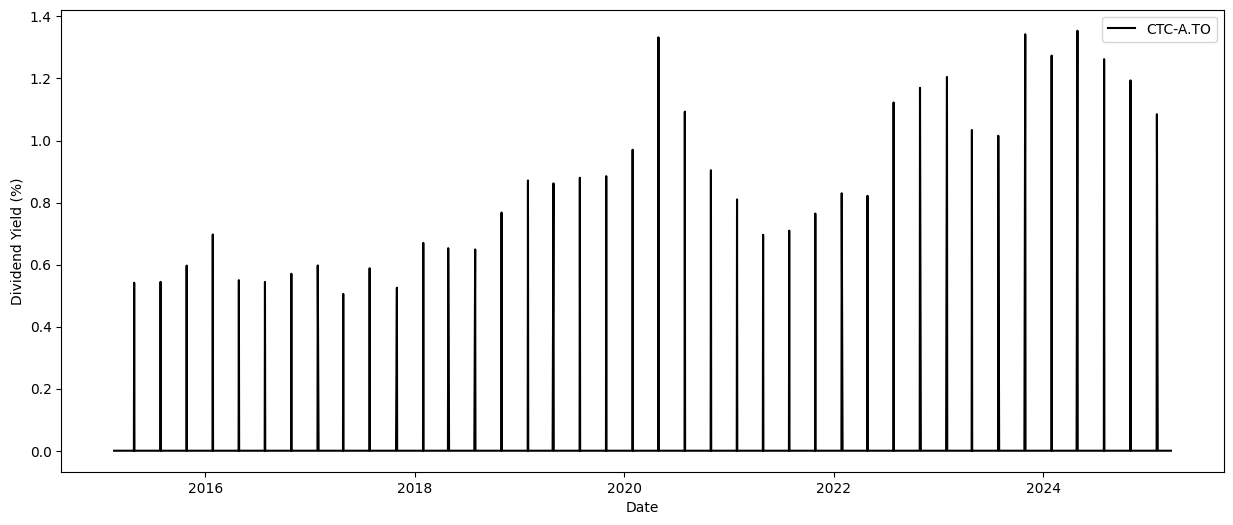

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.162875
share_price      1.000000
Name: share_price, dtype: float64


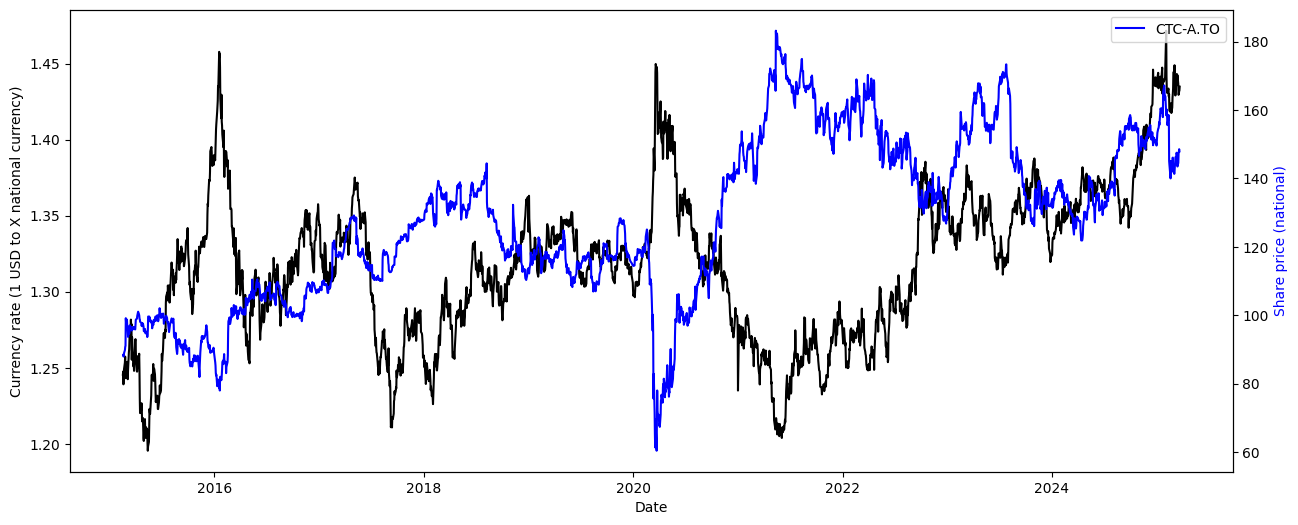

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

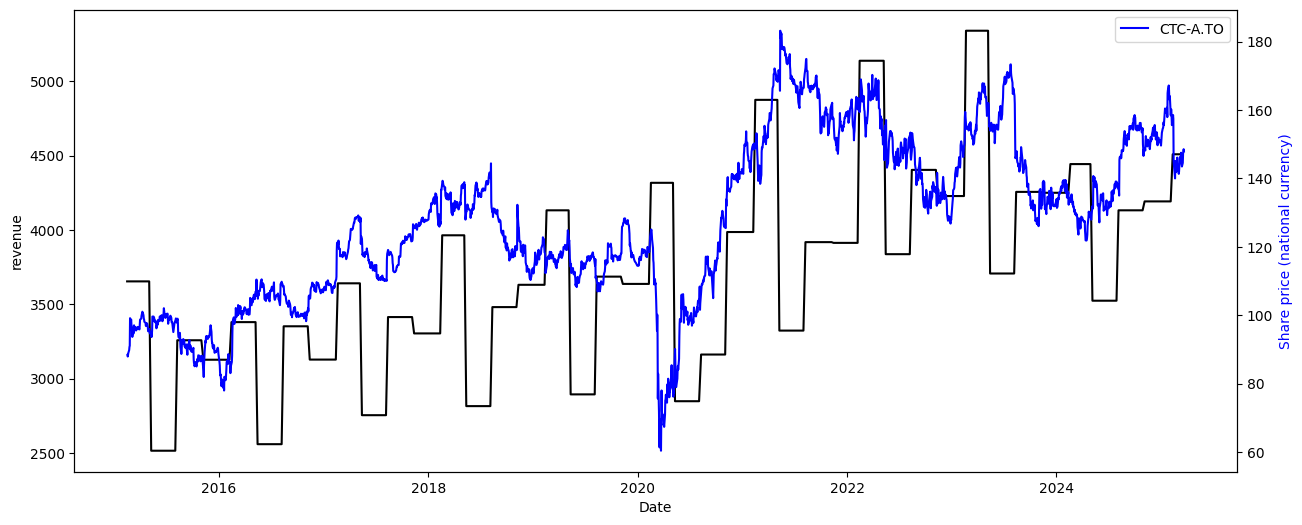

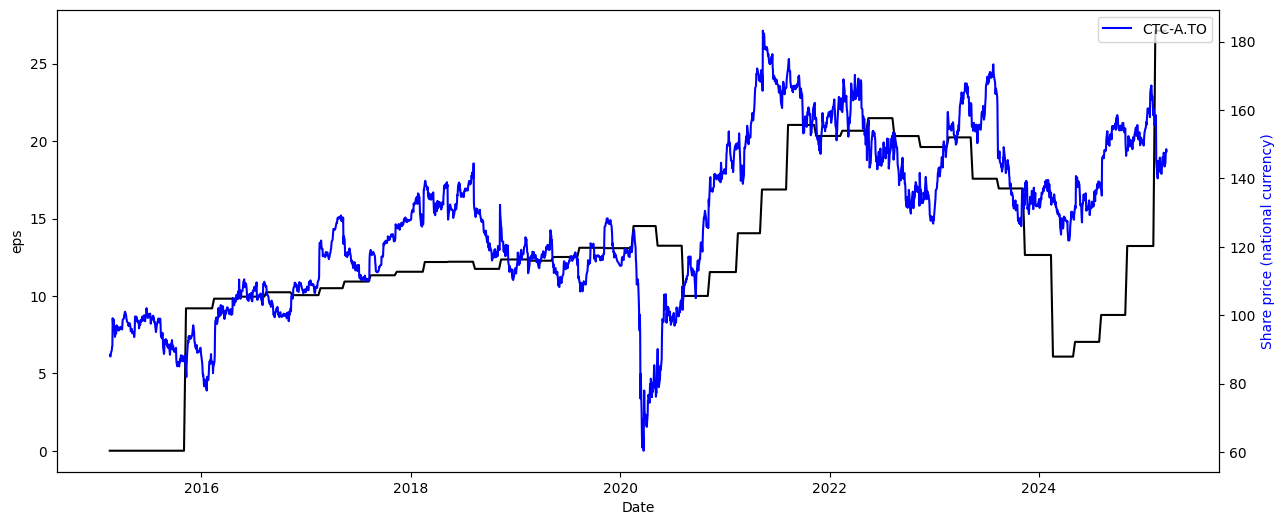

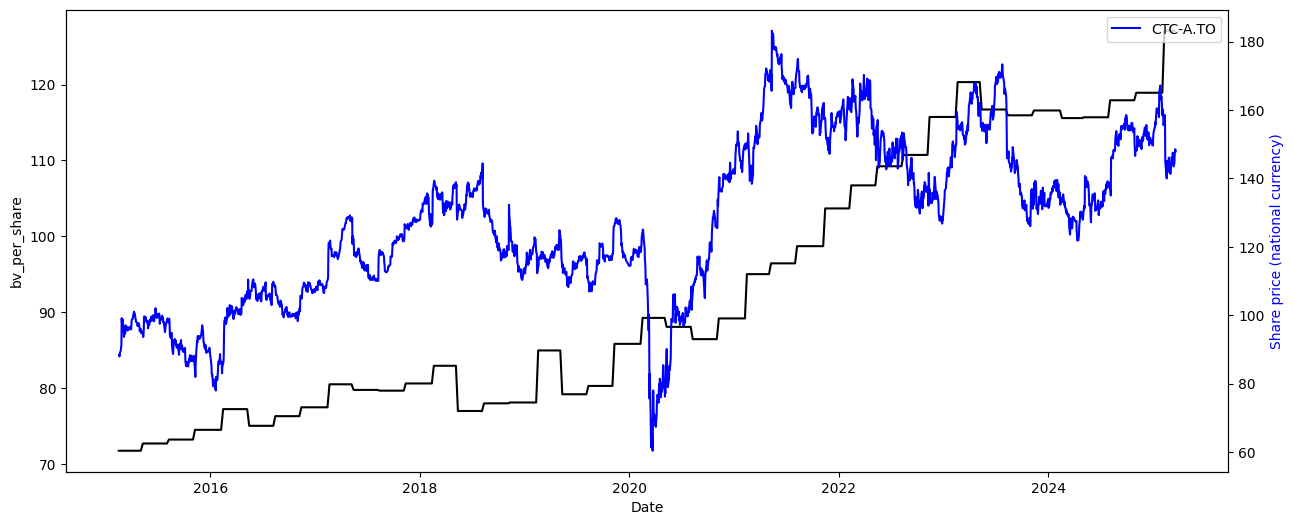

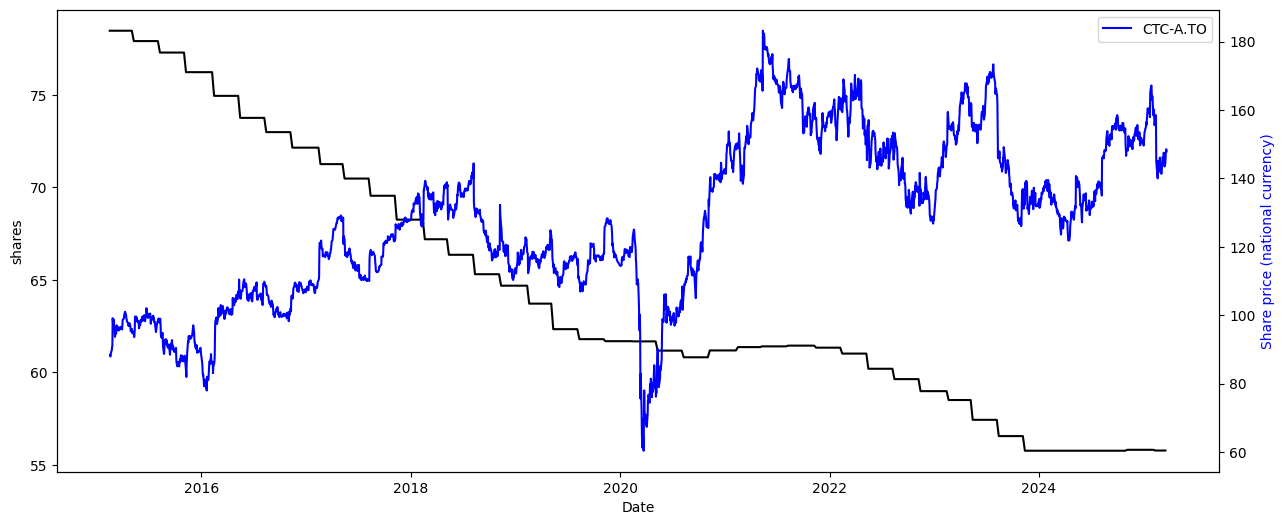

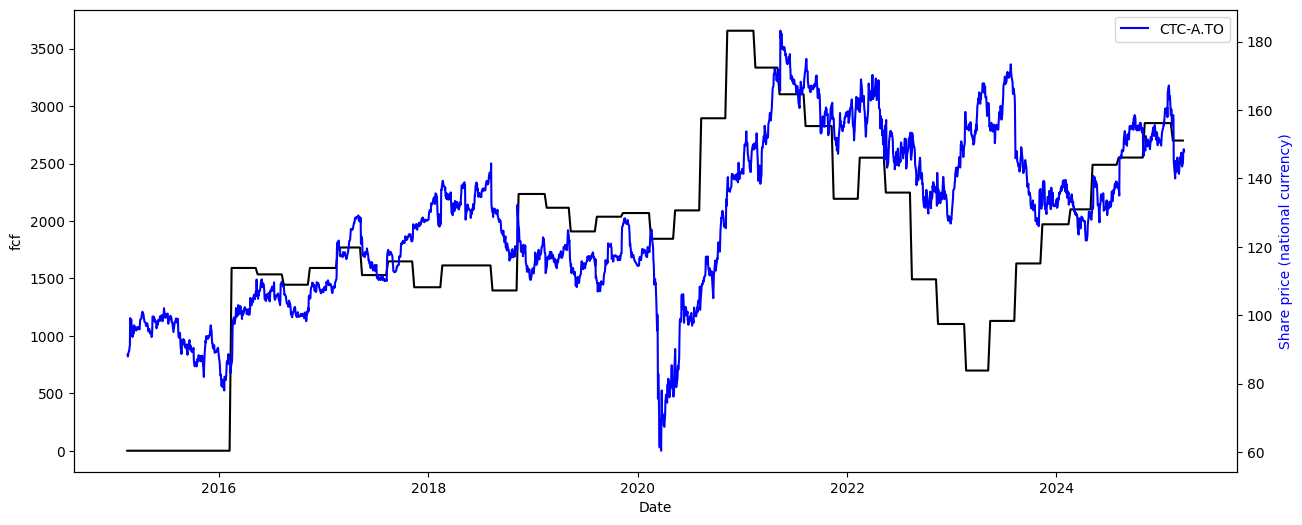

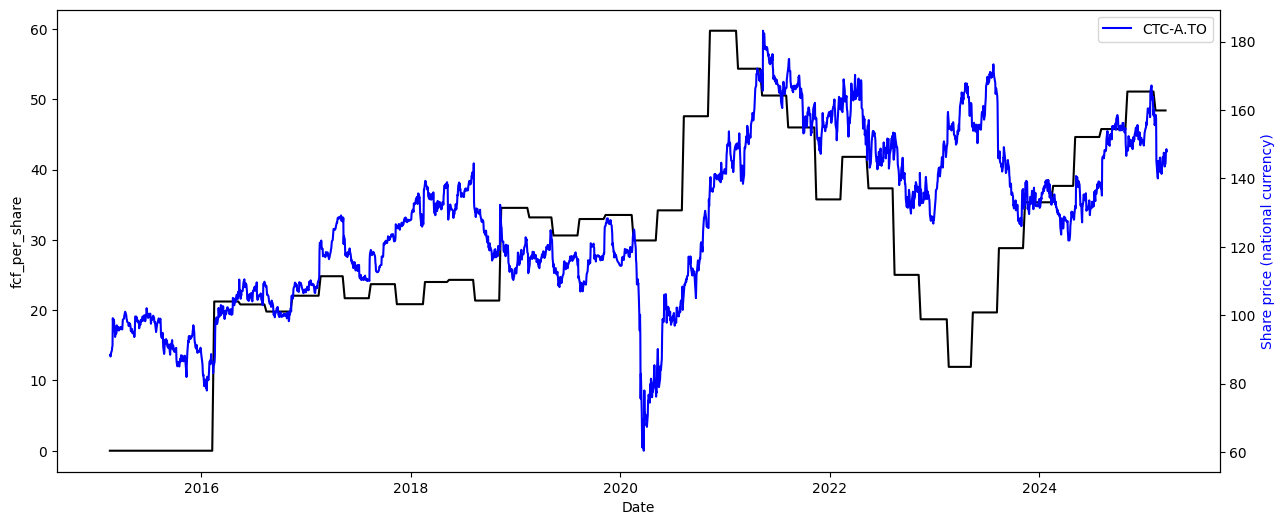

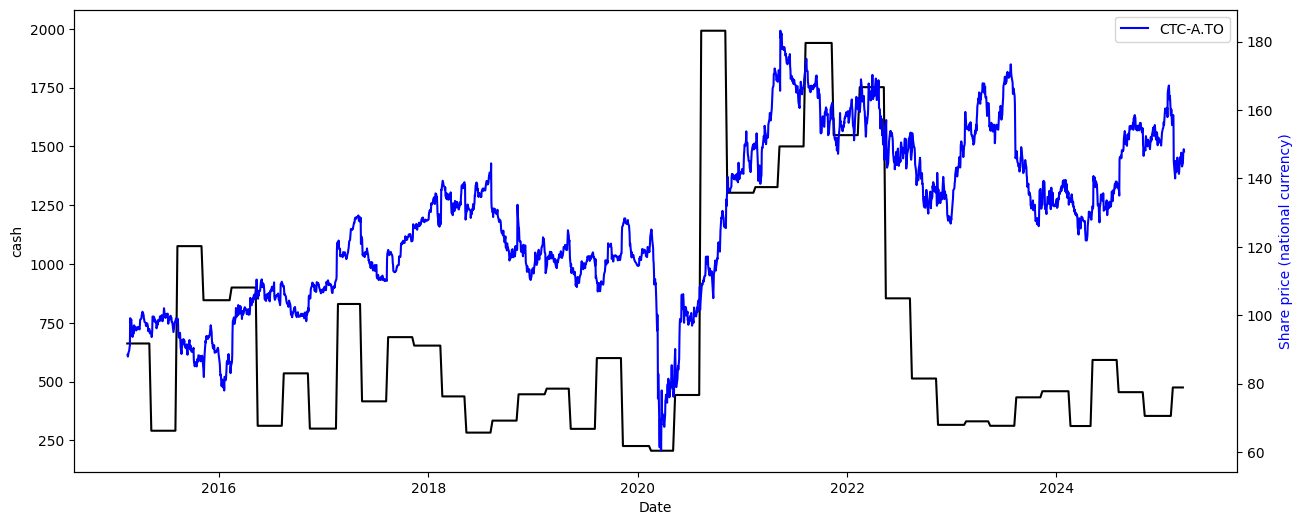

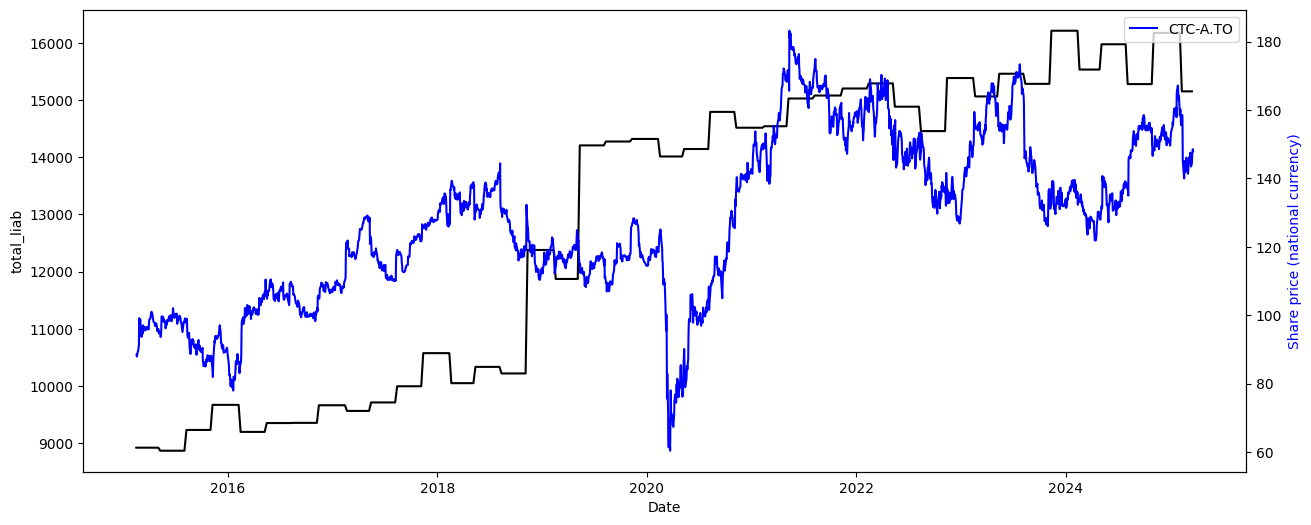

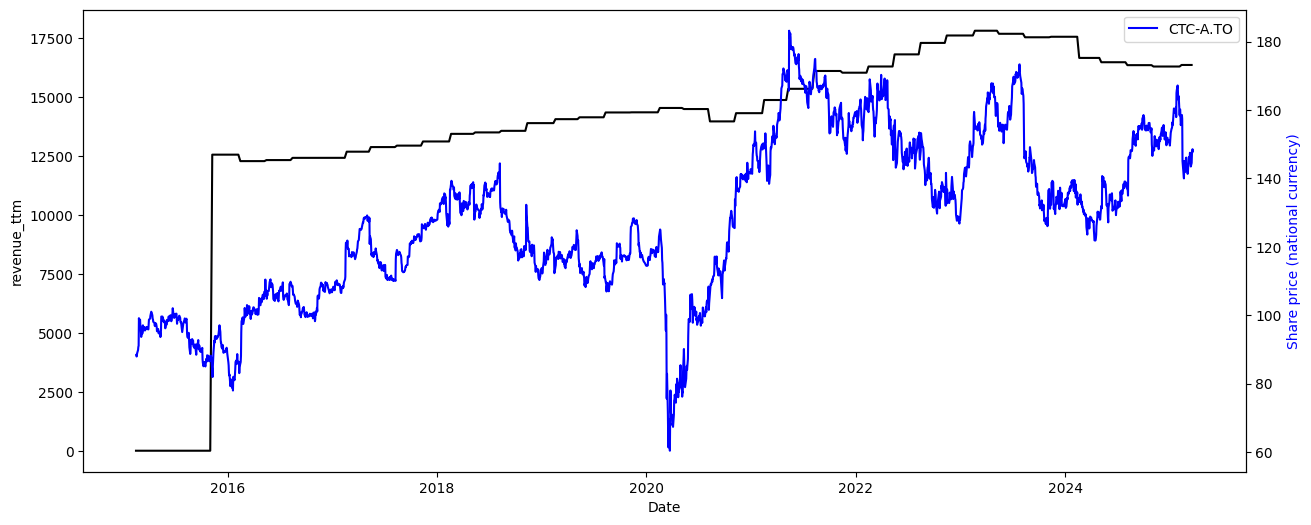

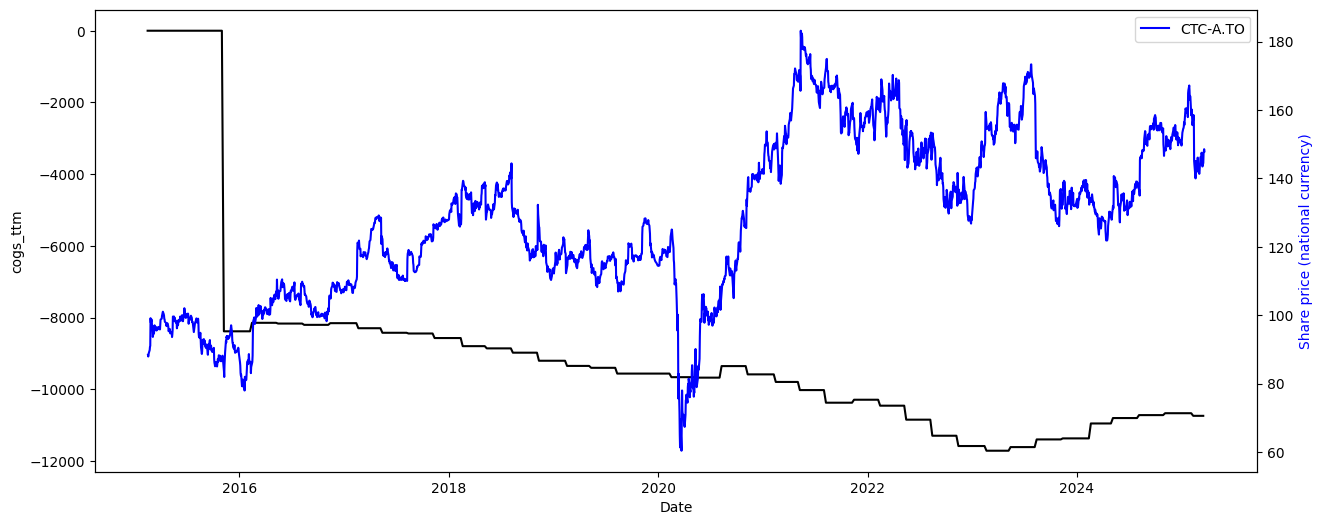

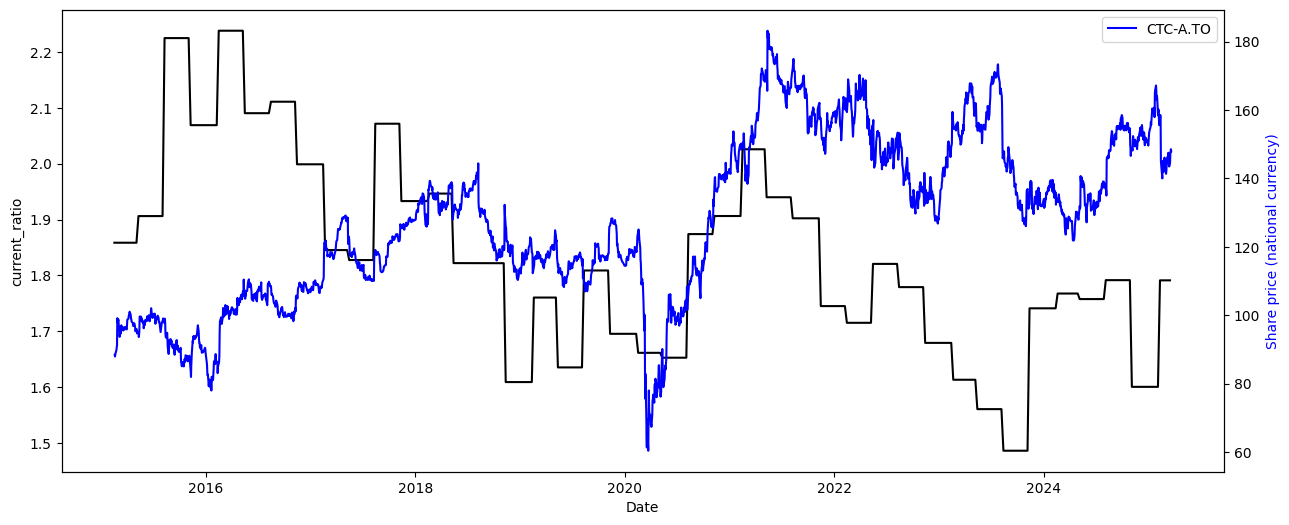

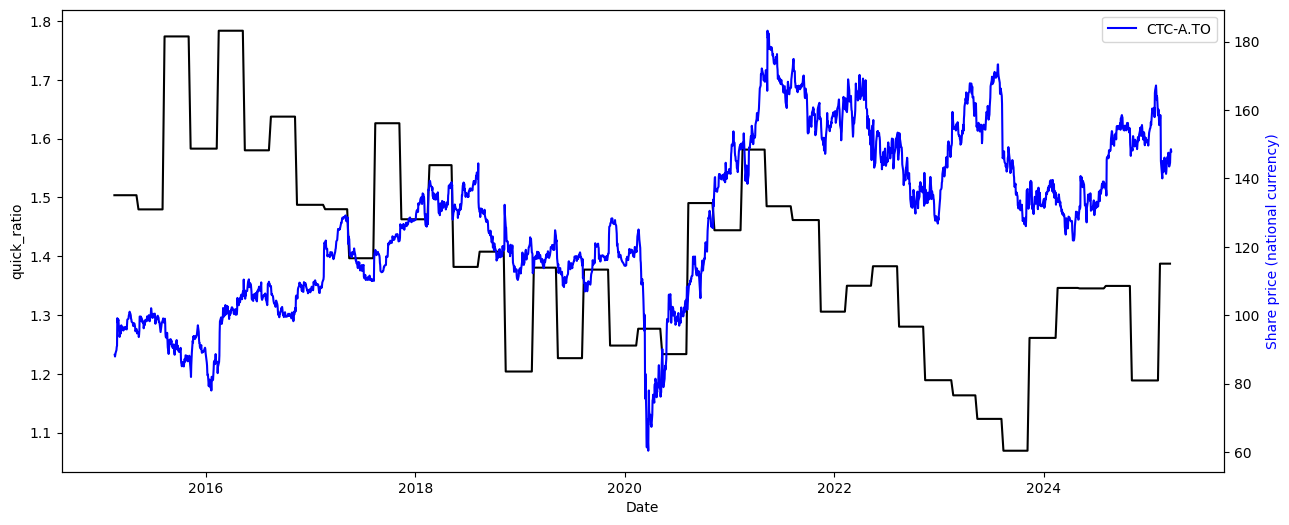

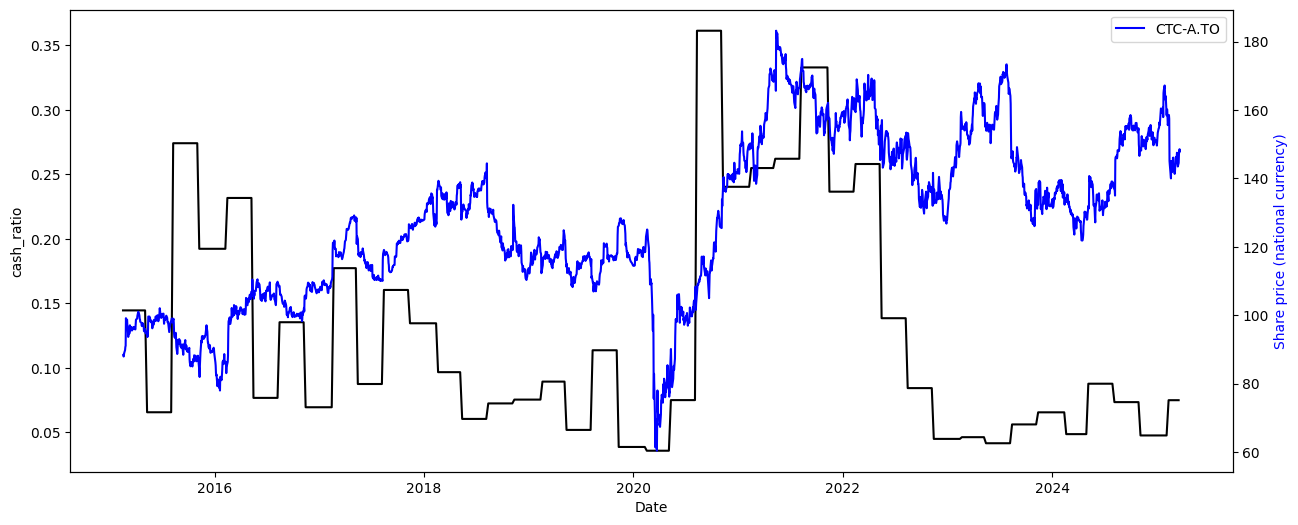

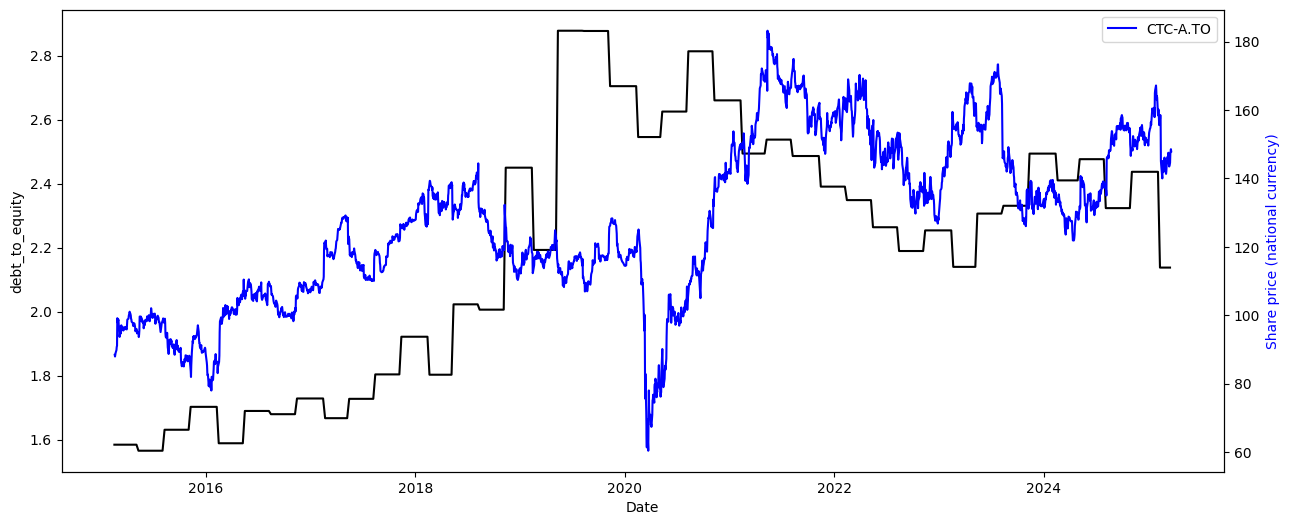

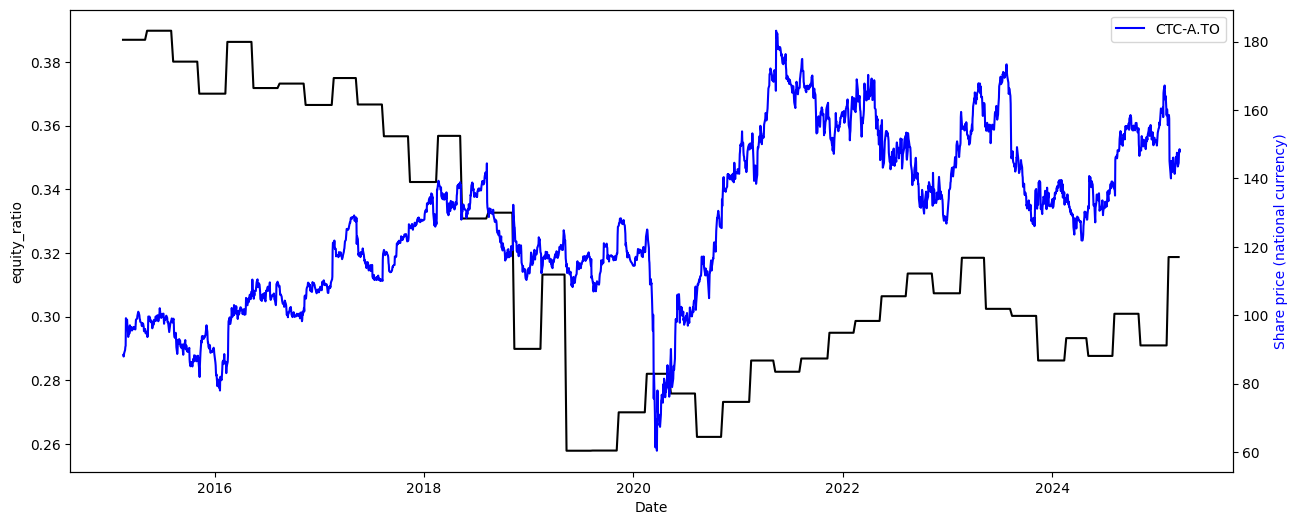

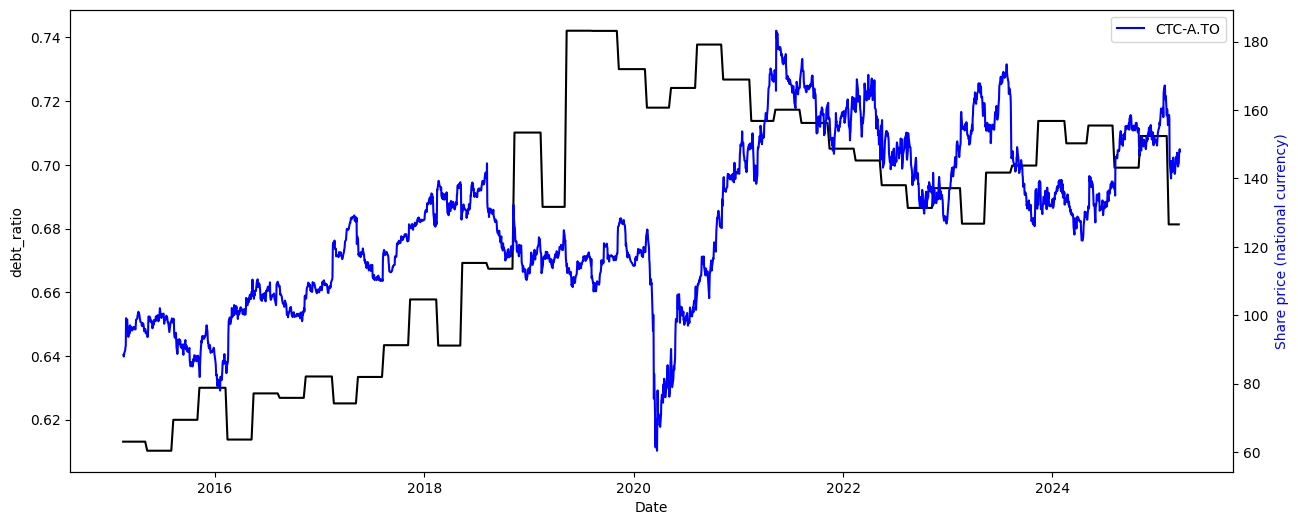

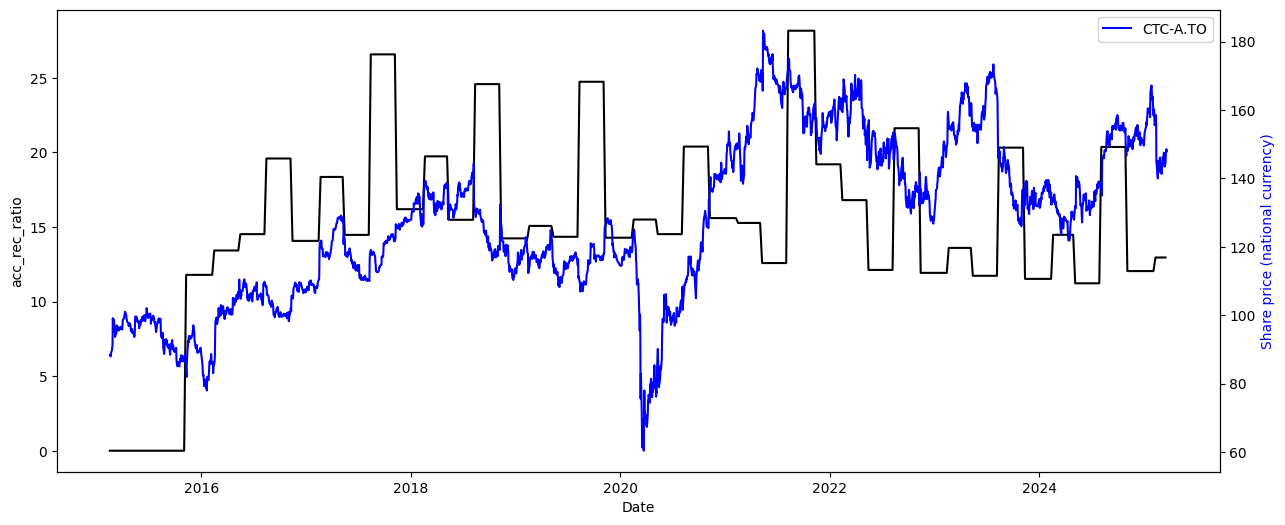

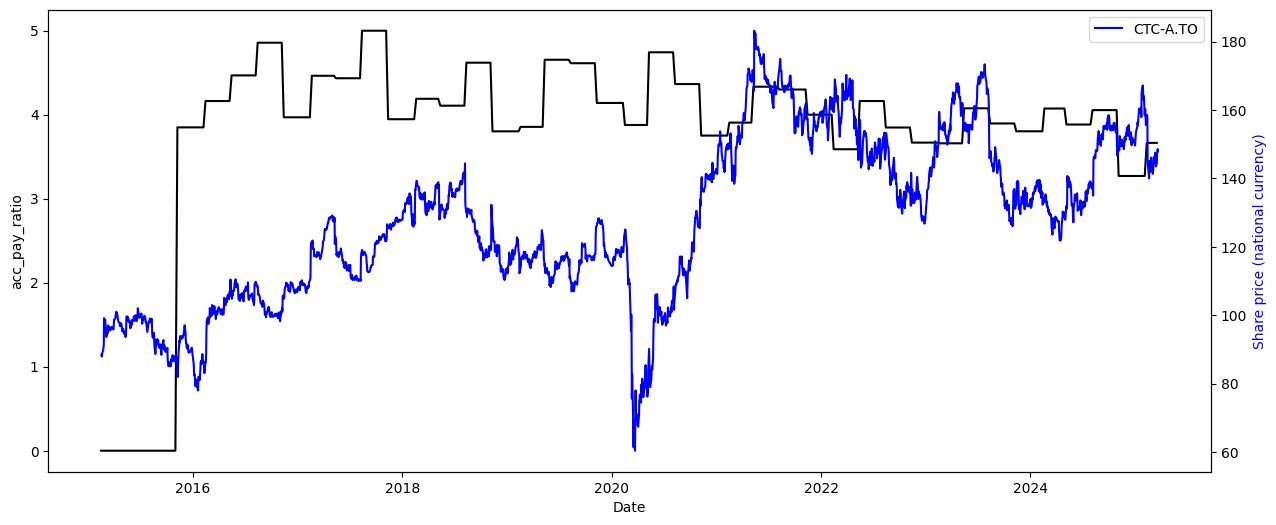

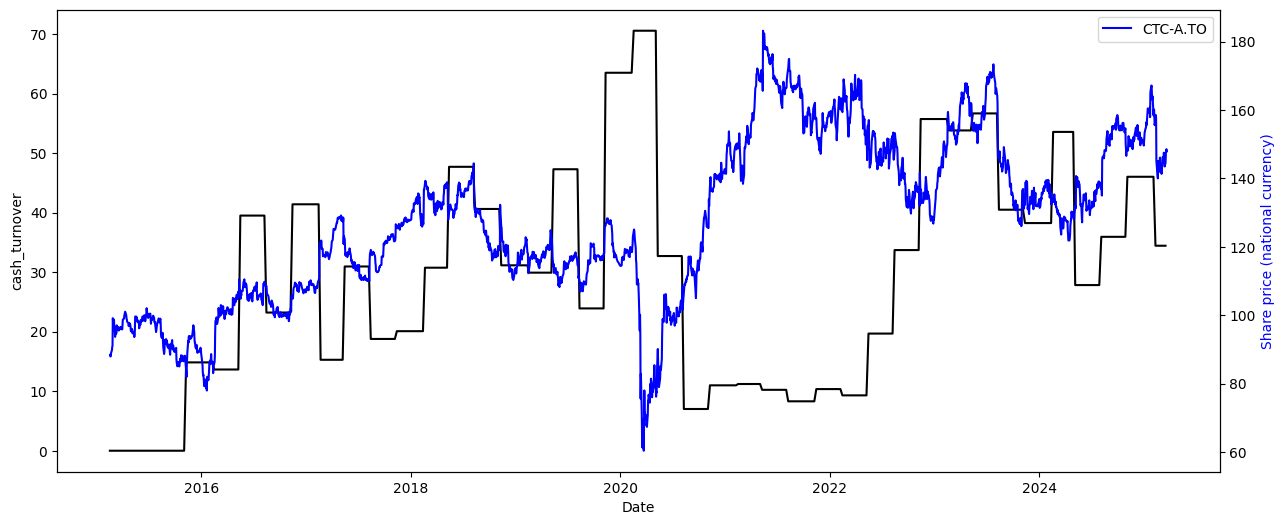

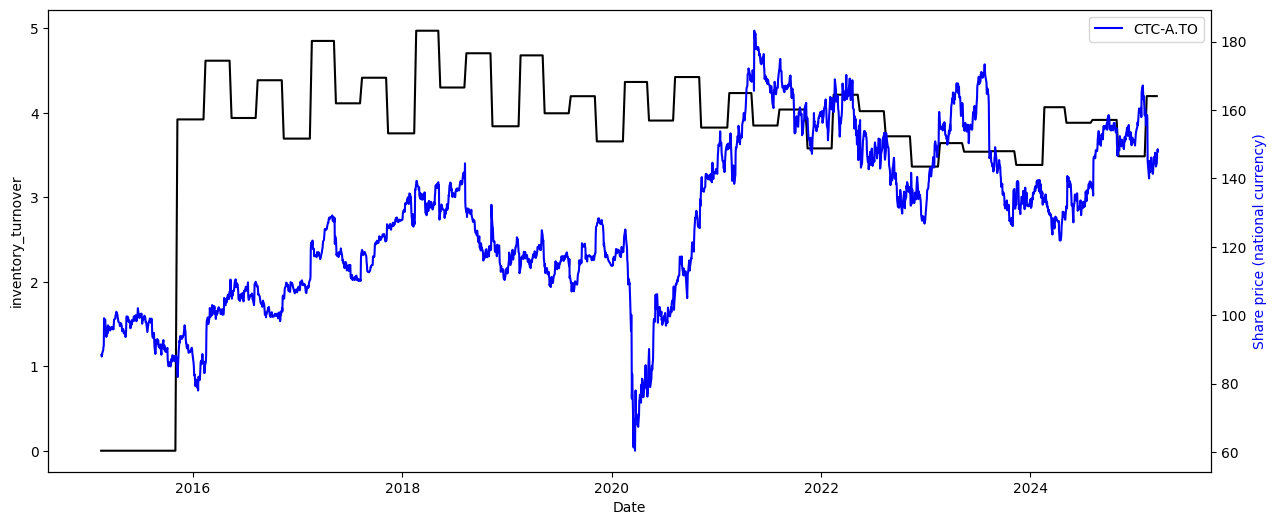

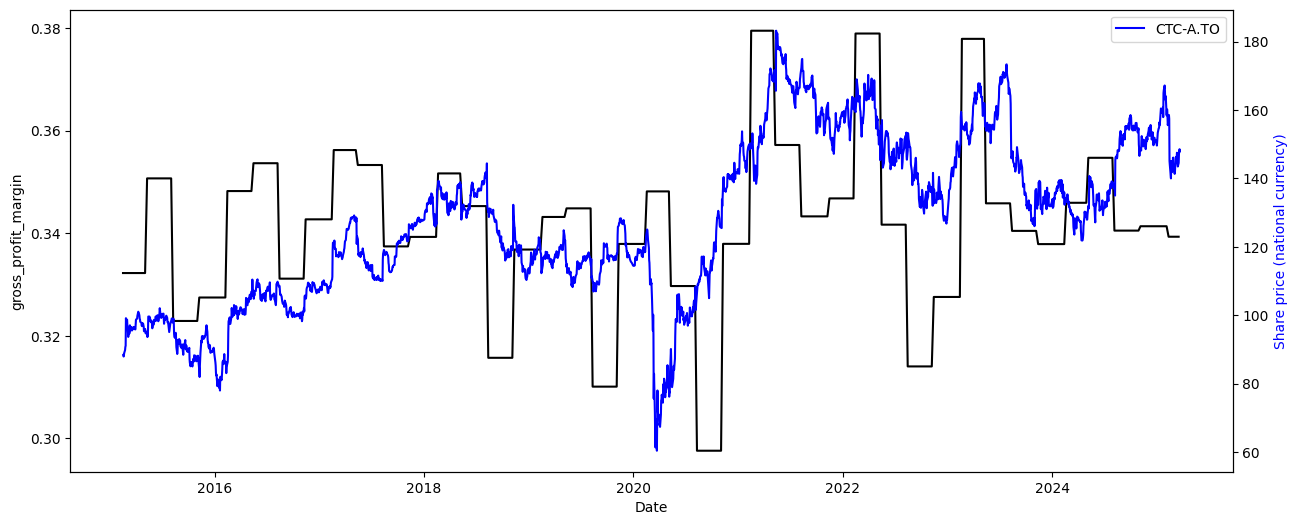

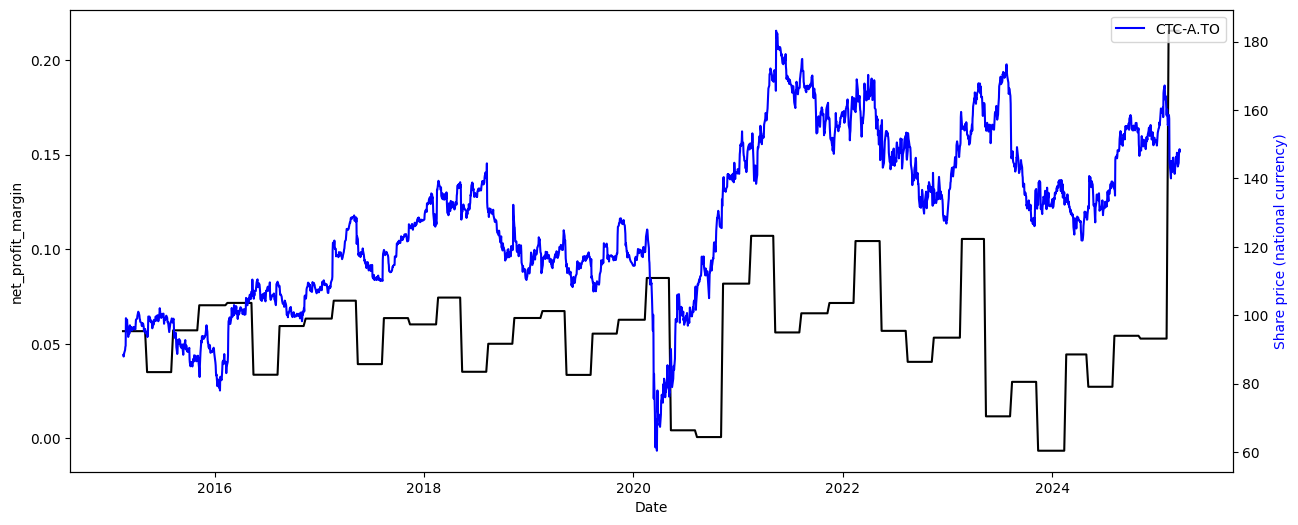

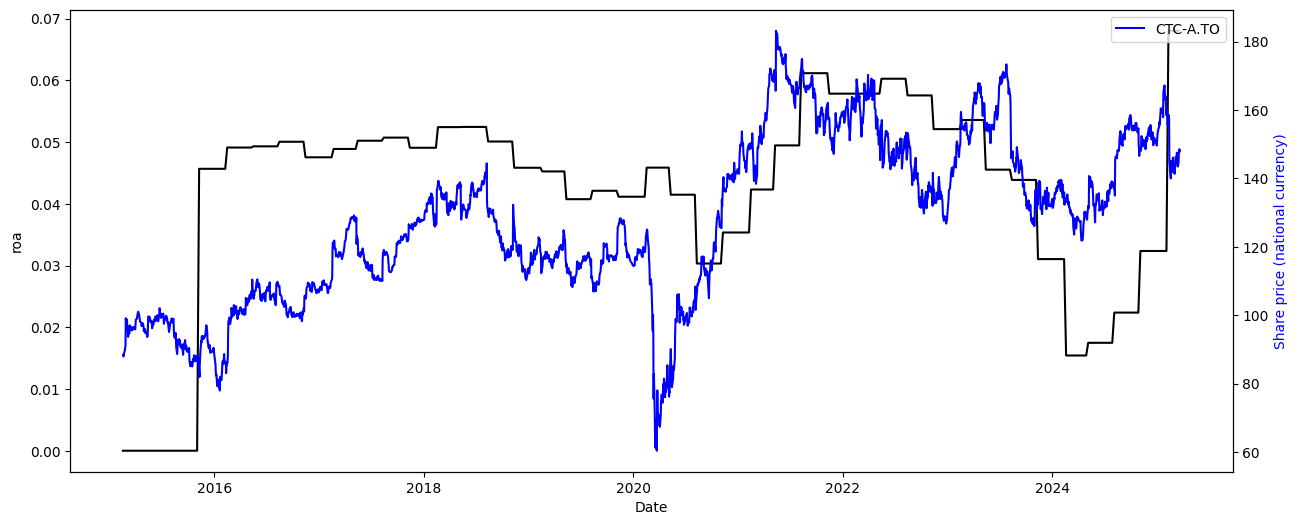

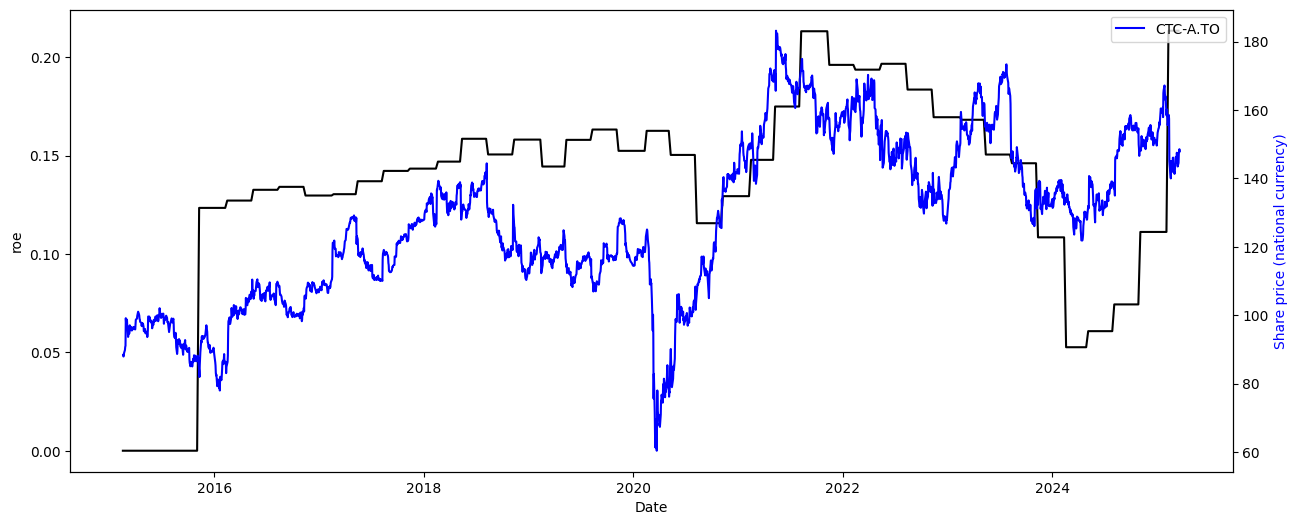

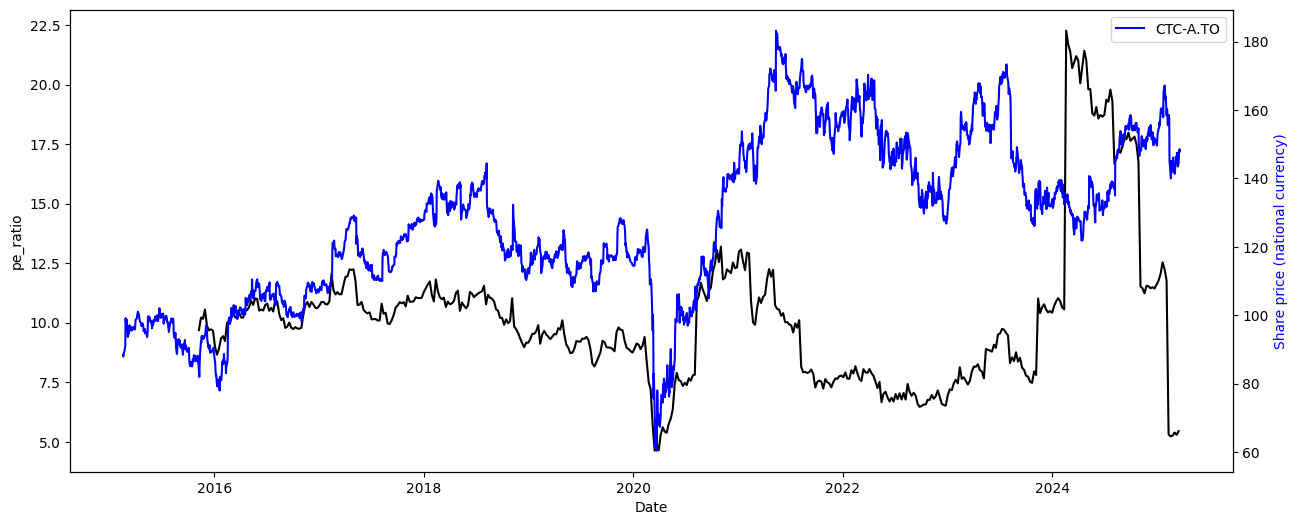

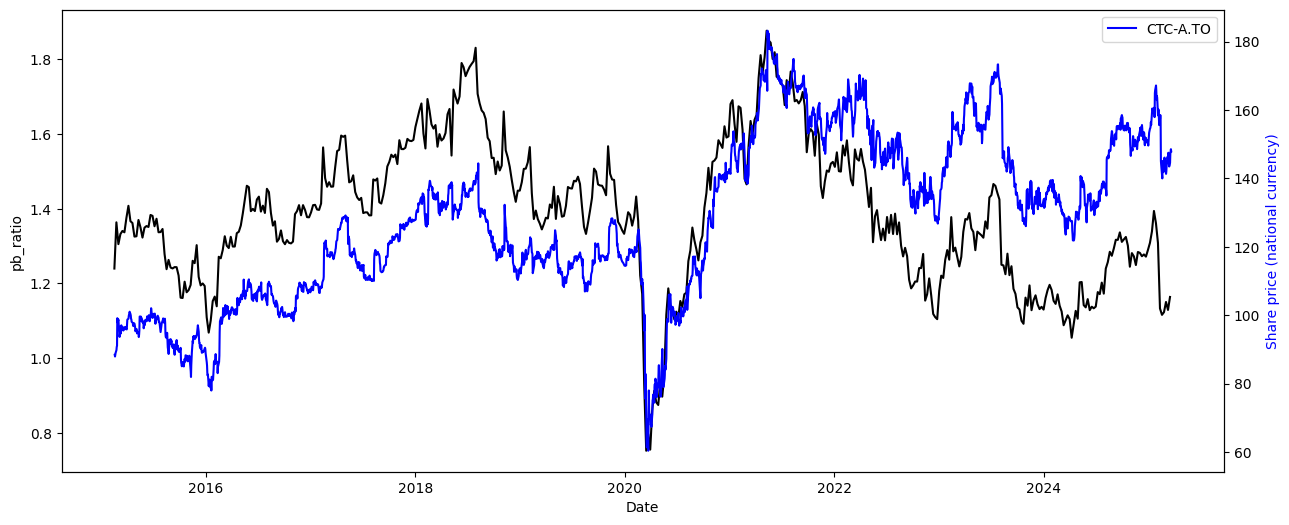

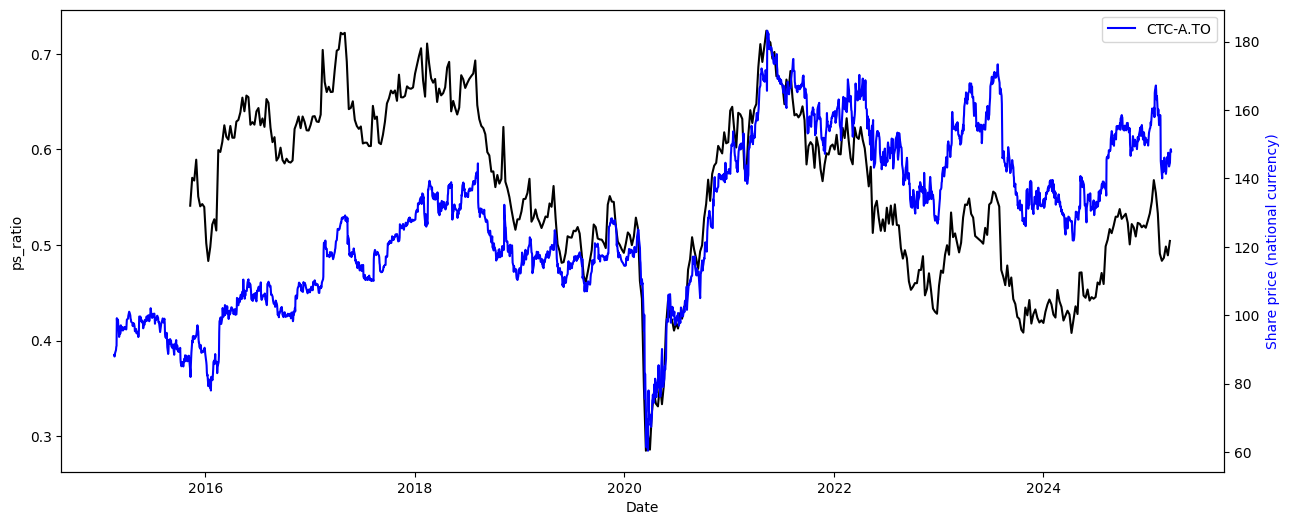

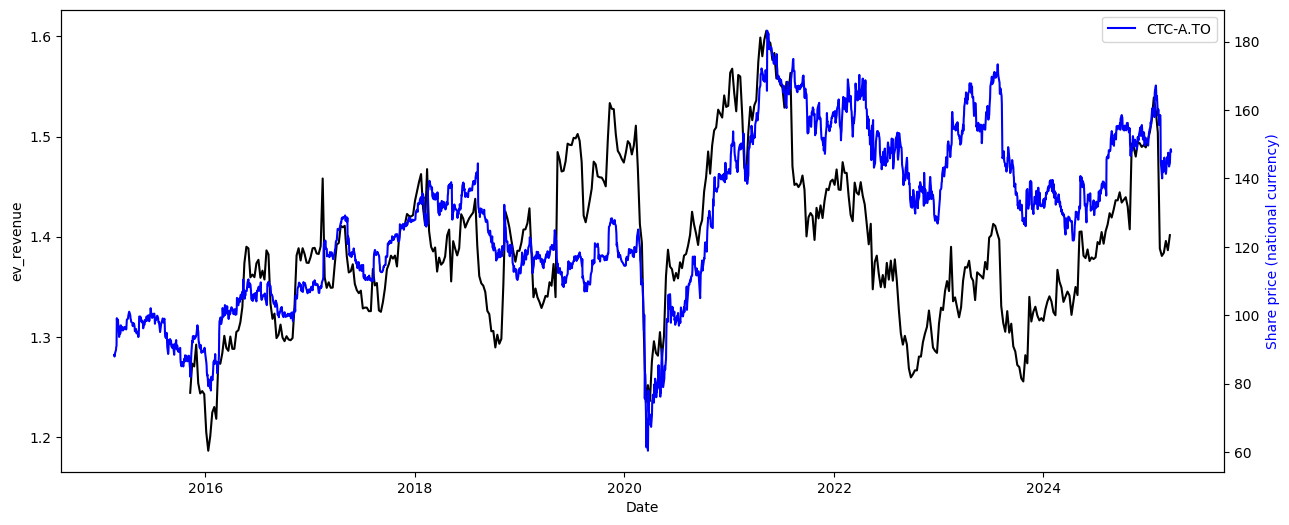

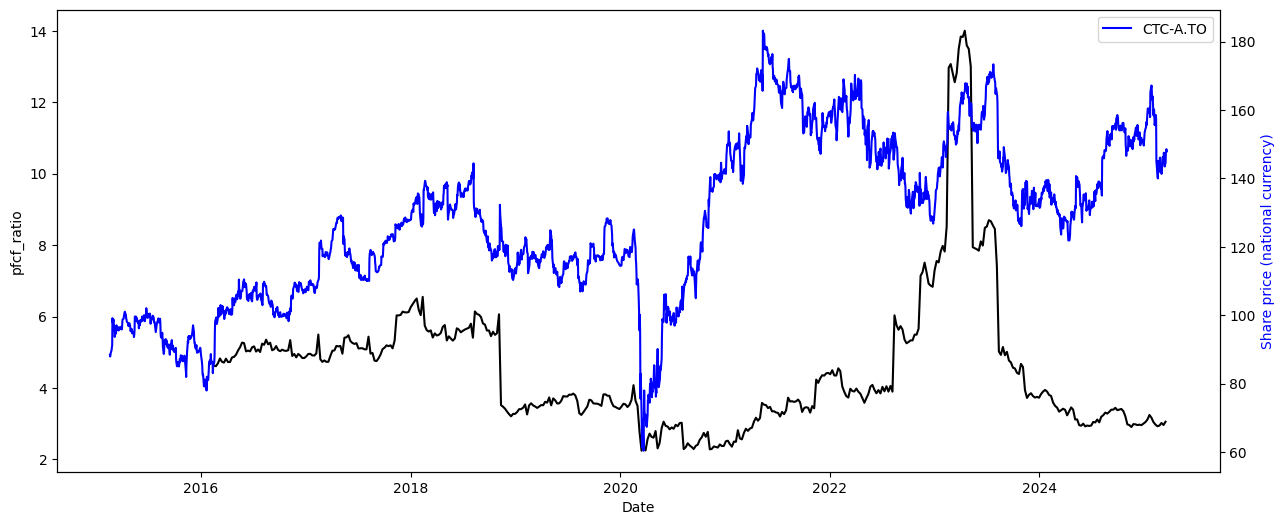

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

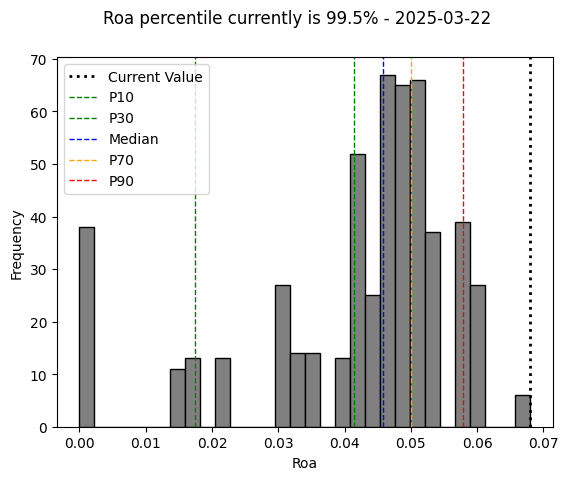

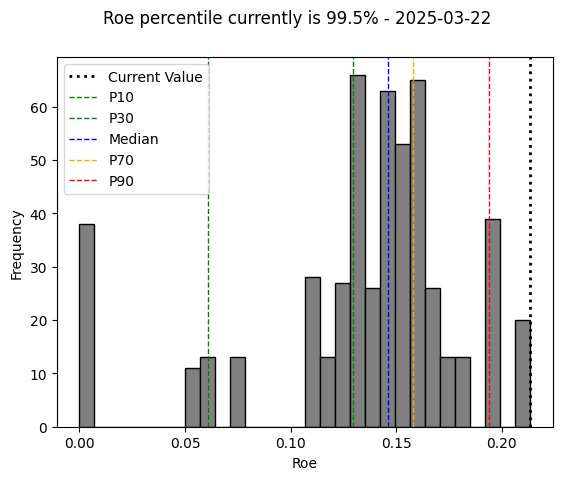

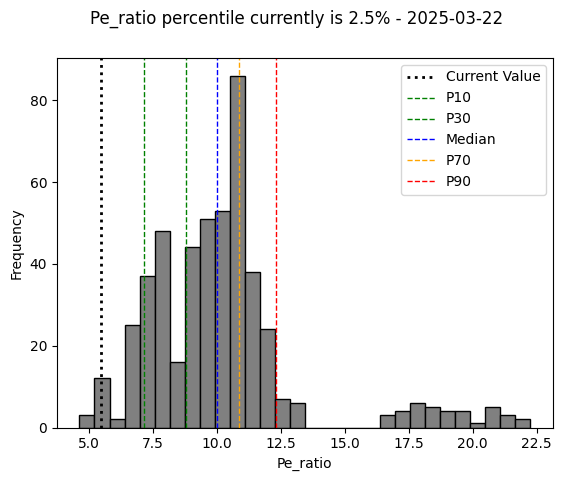

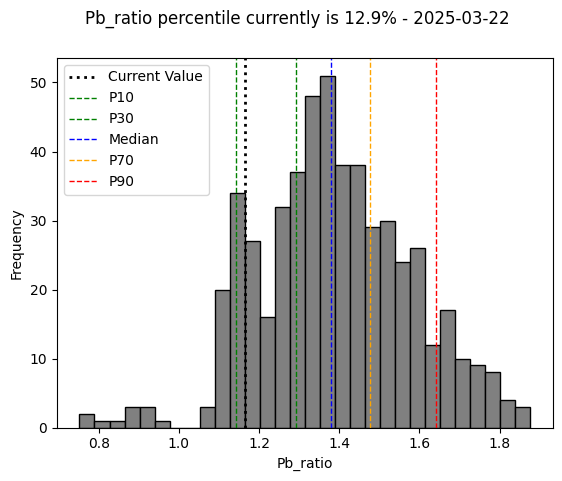

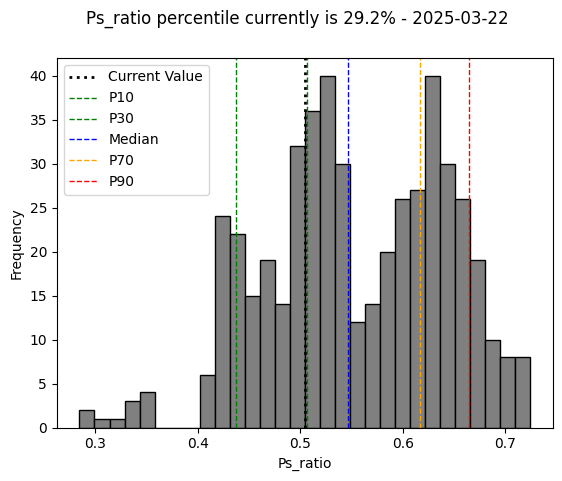

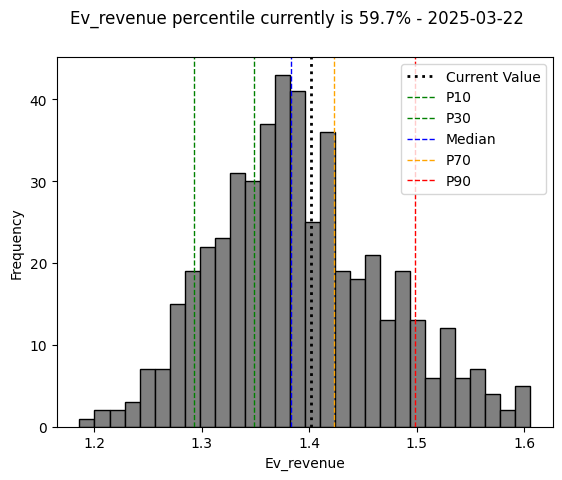

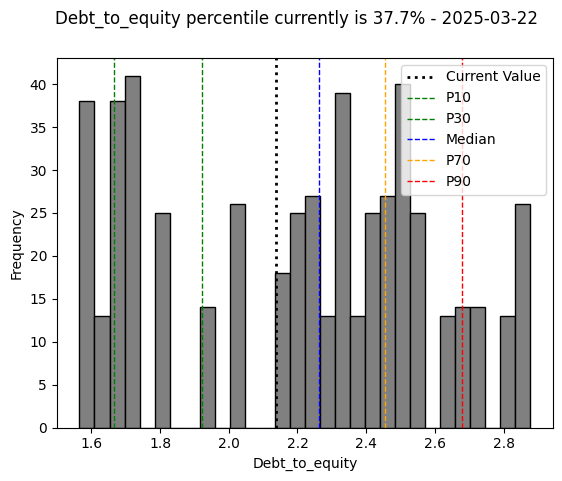

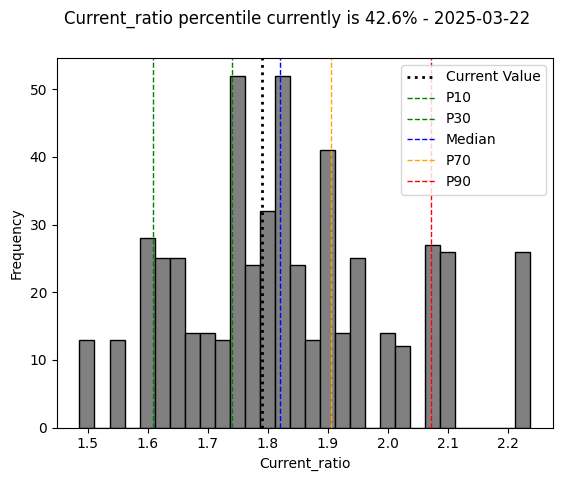

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.949766,-0.792856,0.313748,0.399693,-0.146433,0.089834,-0.095660
roe,0.949766,1.000000,-0.863854,0.302048,0.176741,0.101757,0.374757,-0.272850
pe_ratio,-0.792856,-0.863854,1.000000,0.028479,0.085495,0.181810,-0.022384,0.164877
pb_ratio,0.313748,0.302048,0.028479,1.000000,0.869422,0.631109,-0.022029,0.227275
ps_ratio,0.399693,0.176741,0.085495,0.869422,1.000000,0.396925,-0.502462,0.597276
ev_revenue,-0.146433,0.101757,0.181810,0.631109,0.396925,1.000000,0.521940,-0.059718
debt_to_equity,0.089834,0.374757,-0.022384,-0.022029,-0.502462,0.521940,1.000000,-0.595775
current_ratio,-0.095660,-0.272850,0.164877,0.227275,0.597276,-0.059718,-0.595775,1.000000


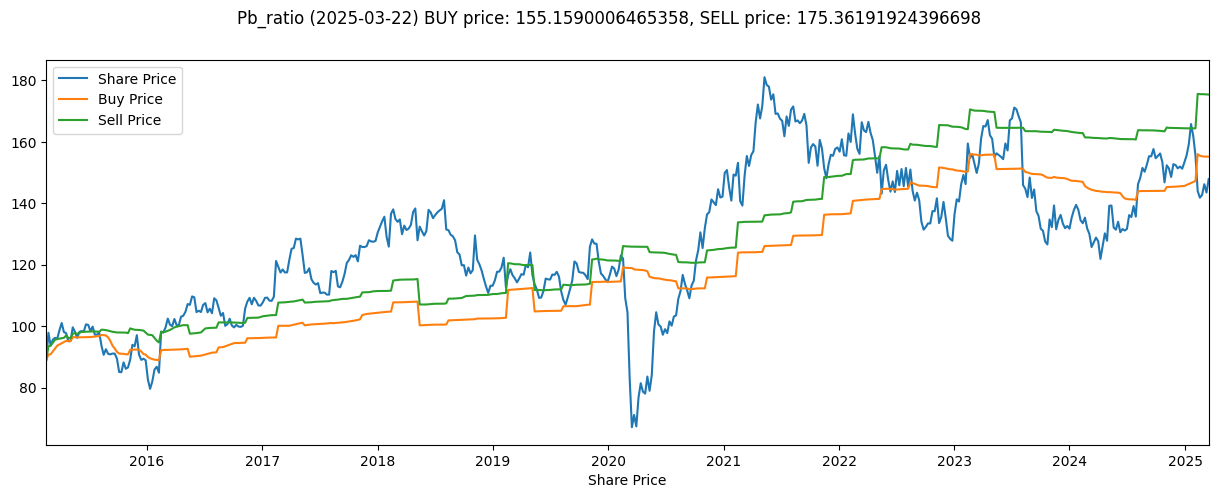

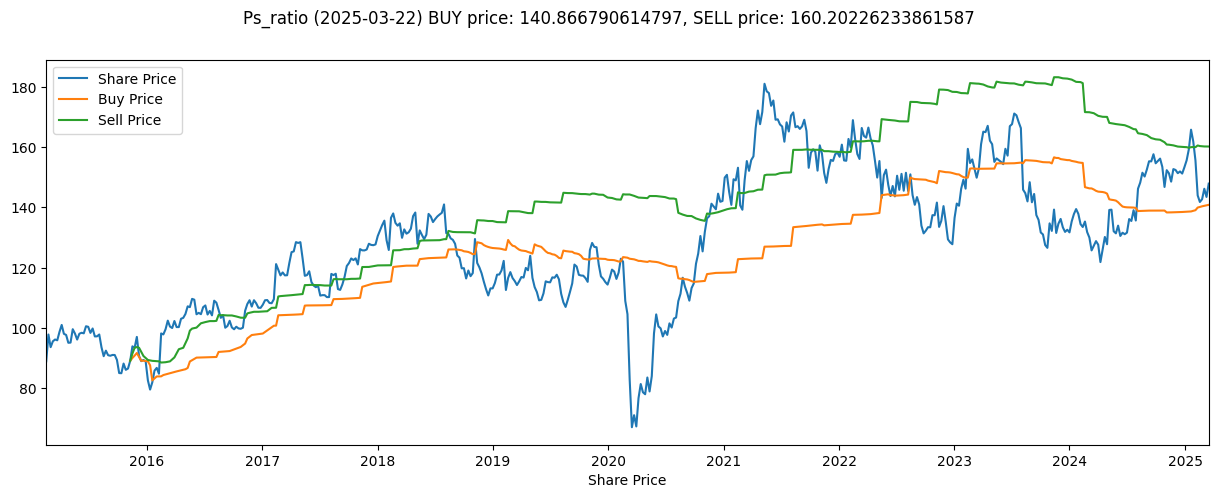

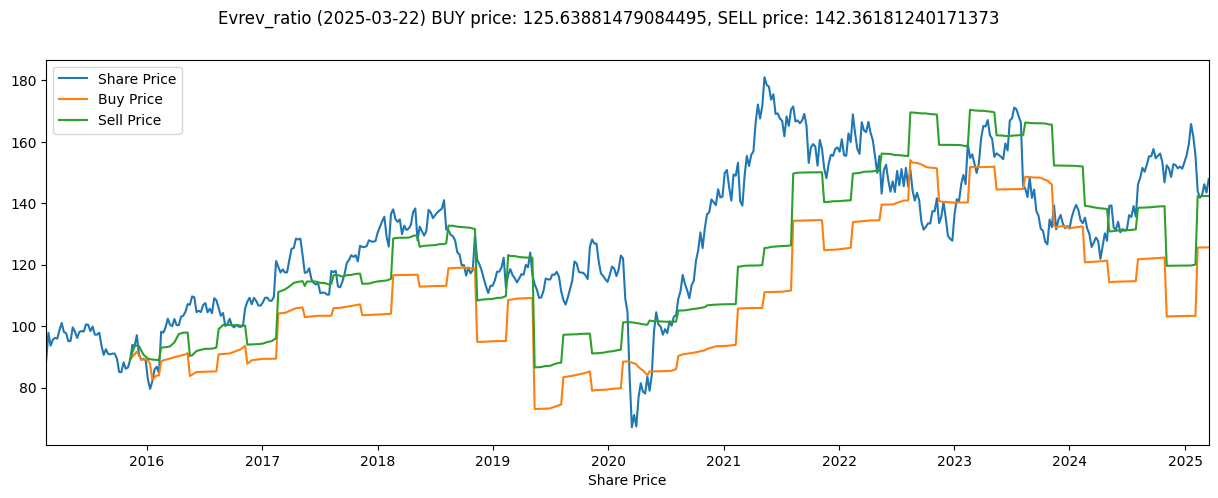

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)